In [ ]:
import os, re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
  accuracy_score,
  f1_score,
  precision_score,
  recall_score,
  classification_report,
  confusion_matrix,
  auc,
  roc_curve,
)

import torch
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW

from transformers import (
  AutoTokenizer,
  AutoModelForSequenceClassification,
  get_linear_schedule_with_warmup,
)

from tqdm.auto import tqdm

/home/microgod/projects/unfake/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
  torch.cuda.manual_seed_all(SEED)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")


DATA_PATH = "../data/"
MODEL_DIR = "./models"
os.makedirs(MODEL_DIR, exist_ok=True)

print(f"Device: {DEVICE}")


Device: cuda


In [9]:
path = DATA_PATH + "politifact_statements.csv"
df = pd.read_csv(path)
df.head()

,verdict,statement,statement_date,statement_source,factcheck_date,url
0,False,"""This Thanksgiving, turkey prices are at their...",2025-11-24,Richard Hudson,2025-11-26,https://www.politifact.com/factchecks/2025/nov...
1,Half True,The Trump administration removed nursing from ...,2025-11-20,Social Media,2025-11-26,https://www.politifact.com/factchecks/2025/nov...
2,False,"""I have just gotten the highest poll numbers o...",2025-11-22,Donald Trump,2025-11-24,https://www.politifact.com/factchecks/2025/nov...
3,False,"""There's about 1,400 criminal illegal aliens t...",2025-11-17,Tricia McLaughlin,2025-11-24,https://www.politifact.com/factchecks/2025/nov...
4,False,"West Virginia is ""the only state losing popula...",2025-11-05,Kayla Young,2025-11-21,https://www.politifact.com/factchecks/2025/nov...


In [ ]:
LABEL_MAP = {
  "True": 1,
  "Mostly True": 1,
  "Half True": 1,
  "Mostly False": 0,
  "False": 0,
  "Pants on Fire": 0,
}

df["label"] = df["verdict"].map(LABEL_MAP)

df.dropna(subset=["label"], inplace=True)
df["label"] = df["label"].astype(int)

print("New label distribution:")
print(df["label"].value_counts())
print(f"\nBalance ratio: {df['label'].value_counts(normalize=True).to_dict()}")


New label distribution:
label
0    15978
1    10021
Name: count, dtype: int64

Balance ratio: {0: 0.6145620985422516, 1: 0.38543790145774837}


In [ ]:
print(f"Original size: {len(df)}")


def remove_spanish(txt: str) -> bool:
  spanish_chars = re.findall(r"[áéíóúñü¿¡]", txt.lower())
  return len(spanish_chars) == 0


df = df[df["statement"].apply(remove_spanish)]

print(f"Cleaned size: {len(df)}")

In [ ]:
from sklearn.utils.class_weight import compute_class_weight


class_weights = compute_class_weight(
  class_weight="balanced", classes=np.unique(df["label"]), y=df["label"]
)
class_weights = torch.tensor(class_weights, dtype=torch.float32)

print("Class distribution:")
print(f"  Fake (0): {len(df[df['label'] == 0])}")
print(f"  Real (1): {len(df[df['label'] == 1])}")
print("Computed class weights:")
print(f"  Fake (0): {class_weights[0]:.4f}")
print(f"  Real (1): {class_weights[1]:.4f}")

Before balancing:
  Fake (0): 15978
  Real (1): 10021

After balancing (undersampling):
  Fake (0): 10021
  Real (1): 10021
  Total: 20042


In [1]:
import nltk

nltk.download("stopwords", quiet=True)
nltk.download("punkt", quiet=True)
nltk.download("punkt_tab", quiet=True)

from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, SnowballStemmer
from nltk.tokenize import word_tokenize


stemmer = SnowballStemmer("english")
stop_words = set(stopwords.words("english"))


important_words = {
  "not",
  "no",
  "never",
  "none",
  "nothing",
  "neither",
  "nobody",
  "nowhere",
  "cannot",
  "couldn't",
  "shouldn't",
  "wouldn't",
  "don't",
  "doesn't",
  "didn't",
  "isn't",
  "aren't",
  "wasn't",
  "weren't",
  "won't",
  "can't",
  "very",
  "only",
  "all",
}
stop_words = stop_words - important_words

print(f"Total stopwords: {len(stop_words)}")
print(f"Sample stopwords: {list(stop_words)[:10]}")

Total stopwords: 182
Sample stopwords: ['during', 'itself', 'then', 've', 'both', 'any', 'can', 'shouldn', 'hers', "i'll"]


In [ ]:
def clean_text(text: str, remove_stopwords=False, apply_stemming=False):
  text = text.lower()
  text = re.sub(r"[^a-z0-9\s]", " ", text)  # [^\x00-\x7F]
  text = re.sub(r"\s+", " ", text)
  text = text.strip()

  tokens = text.split()

  if remove_stopwords:
    tokens = [word for word in tokens if word not in stop_words]

  if apply_stemming:
    tokens = [stemmer.stem(word) for word in tokens]

  return " ".join(tokens)


df["statement"] = (
  df["statement"]
  .str.strip('"')
  .str.replace("&", " and ")
  .str.replace(r"\\u\d{3,4}", "", regex=True)
)
df["cleaned_statement"] = df["statement"].apply(clean_text)

print("Example of text cleaning:")
print("=" * 80)
sample_idx = df.index[0]
print(f"Original:  {df.loc[sample_idx, 'statement'][:100]}...")
print(f"Cleaned:   {df.loc[sample_idx, 'cleaned_statement'][:100]}...")
print("=" * 80)

df.head()

Example of text cleaning:
Original:  North Carolina Republican Senate candidate Thom Tillis would let insurance companies "deny coverage ...
Cleaned:   north carolina republican senat candid thom tilli would let insur compani "deni coverag pre-exist co...


,verdict,statement,statement_date,statement_source,factcheck_date,url,label,cleaned_statement
0,Mostly True,North Carolina Republican Senate candidate Tho...,2014-02-12,Patriot Majority USA,2014-02-13,https://www.politifact.com/factchecks/2014/feb...,1,north carolina republican senat candid thom ti...
1,True,"""From 2003 to 2006, 'Sesame Street' made more ...",2011-02-16,Jim DeMint,2011-02-28,https://www.politifact.com/factchecks/2011/feb...,1,"""from 2003 2006, sesam street made $211 millio..."
2,Mostly True,"""I built that border fence in San Diego...and ...",2007-09-05,Duncan Hunter,2007-09-03,https://www.politifact.com/factchecks/2007/sep...,1,"""i built border fenc san diego...and reduc smu..."
3,False,"""Covid-19 is NOT killing people. Weak immune s...",2020-08-31,Viral image,2020-09-04,https://www.politifact.com/factchecks/2020/sep...,0,"""covid-19 not kill people. weak immun system b..."
4,Mostly True,"""Corporate entities are paying a lot less taxe...",2017-01-20,Kip Kendrick,2017-03-02,https://www.politifact.com/factchecks/2017/mar...,1,"""corpor entiti pay lot less tax year past. par..."


In [ ]:
train_df, temp_df = train_test_split(
  df, test_size=0.2, random_state=SEED, stratify=df["label"]
)
val_df, test_df = train_test_split(
  temp_df, test_size=0.5, random_state=SEED, stratify=temp_df["label"]
)

print(f"Train size: {len(train_df)}")
print(f"Validation size: {len(val_df)}")
print(f"Test size: {len(test_df)}")
print(f"\nTrain label distribution:\n{train_df['label'].value_counts(normalize=True)}")

Train size: 20799
Validation size: 2600
Test size: 2600

Train label distribution:
label
0    0.614549
1    0.385451
Name: proportion, dtype: float64


In [ ]:
MODEL_NAME = "RoBERTa-base"
MAX_LENGTH = 256
BATCH_SIZE = 16
LEARNING_RATE = 2e-5
NUM_EPOCHS = 4
WARMUP_RATIO = 0.1
WEIGHT_DECAY = 0.01

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
print(f"Loaded tokenizer: {MODEL_NAME}")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Loaded tokenizer: roberta-base


In [ ]:
class FakeNewsDataset(Dataset):
  def __init__(self, texts, labels, tokenizer, max_length):
    self.texts = texts.tolist()
    self.labels = labels.tolist()
    self.tokenizer = tokenizer
    self.max_length = max_length

  def __len__(self):
    return len(self.texts)

  def __getitem__(self, idx):
    text = str(self.texts[idx])
    label = self.labels[idx]

    encoding = self.tokenizer(
      text,
      max_length=self.max_length,
      padding="max_length",
      truncation=True,
      return_tensors="pt",
    )

    return {
      "input_ids": encoding["input_ids"].flatten(),
      "attention_mask": encoding["attention_mask"].flatten(),
      "label": torch.tensor(label, dtype=torch.long),
    }


train_dataset = FakeNewsDataset(
  train_df["cleaned_statement"], train_df["label"], tokenizer, MAX_LENGTH
)
val_dataset = FakeNewsDataset(
  val_df["cleaned_statement"], val_df["label"], tokenizer, MAX_LENGTH
)
test_dataset = FakeNewsDataset(
  test_df["cleaned_statement"], test_df["label"], tokenizer, MAX_LENGTH
)


train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE * 2, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE * 2, shuffle=False)

print(f"Train batches: {len(train_loader)}")
print(f"Validation batches: {len(val_loader)}")
print(f"Test batches: {len(test_loader)}")

Train batches: 1300
Validation batches: 163
Test batches: 163


In [ ]:
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=2)
model.to(DEVICE)

optimizer = AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

total_steps = len(train_loader) * NUM_EPOCHS
warmup_steps = int(total_steps * WARMUP_RATIO)

scheduler = get_linear_schedule_with_warmup(
  optimizer, num_warmup_steps=warmup_steps, num_training_steps=total_steps
)

print(f"Model: {MODEL_NAME}")
print(f"Using weighted CrossEntropyLoss with class weights: {class_weights.tolist()}")
print(f"Total training steps: {total_steps}")
print(f"Warmup steps: {warmup_steps}")

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Class weights: tensor([0.8136, 1.2972], device='cuda:0')
Total training steps: 5200
Warmup steps: 520


In [ ]:
def train_epoch(model, dataloader, optimizer, scheduler, device):
  model.train()
  total_loss = 0
  all_preds = []
  all_labels = []

  progress_bar = tqdm(dataloader, desc="Training")

  for batch in progress_bar:
    input_ids = batch["input_ids"].to(device)
    attention_mask = batch["attention_mask"].to(device)
    labels = batch["label"].to(device)

    optimizer.zero_grad()

    outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
    loss = outputs.loss
    logits = outputs.logits

    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
    optimizer.step()
    scheduler.step()

    total_loss += loss.item()
    preds = torch.argmax(logits, dim=1)
    all_preds.extend(preds.cpu().numpy())
    all_labels.extend(labels.cpu().numpy())

    progress_bar.set_postfix({"loss": loss.item()})

  avg_loss = total_loss / len(dataloader)
  accuracy = accuracy_score(all_labels, all_preds)
  f1 = f1_score(all_labels, all_preds, average="weighted")

  return avg_loss, accuracy, f1


def evaluate(model, dataloader, device):
  model.eval()
  total_loss = 0
  all_preds = []
  all_labels = []
  all_probs = []

  with torch.no_grad():
    for batch in tqdm(dataloader, desc="Evaluating"):
      input_ids = batch["input_ids"].to(device)
      attention_mask = batch["attention_mask"].to(device)
      labels = batch["label"].to(device)

      outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
      loss = outputs.loss
      logits = outputs.logits
      total_loss += loss.item()

      preds = torch.argmax(logits, dim=1)
      probs = torch.softmax(logits, dim=1)

      all_preds.extend(preds.cpu().numpy())
      all_labels.extend(labels.cpu().numpy())
      all_probs.extend(probs[:, 1].cpu().numpy())

  avg_loss = total_loss / len(dataloader)
  accuracy = accuracy_score(all_labels, all_preds)
  f1 = f1_score(all_labels, all_preds, average="weighted")
  precision = precision_score(all_labels, all_preds, average="weighted")
  recall = recall_score(all_labels, all_preds, average="weighted")

  return {
    "loss": avg_loss,
    "accuracy": accuracy,
    "f1": f1,
    "precision": precision,
    "recall": recall,
    "predictions": all_preds,
    "labels": all_labels,
    "probabilities": all_probs,
  }

In [ ]:
best_val_f1 = 0
patience = 2
patience_counter = 0
history = {
  "train_loss": [],
  "train_acc": [],
  "train_f1": [],
  "val_loss": [],
  "val_acc": [],
  "val_f1": [],
}

print("Starting training...")
print("=" * 60)

for epoch in range(NUM_EPOCHS):
  print(f"\nEpoch {epoch + 1}/{NUM_EPOCHS}")
  print("-" * 40)

  train_loss, train_acc, train_f1 = train_epoch(
    model, train_loader, optimizer, scheduler, DEVICE
  )

  val_results = evaluate(model, val_loader, DEVICE)

  history["train_loss"].append(train_loss)
  history["train_acc"].append(train_acc)
  history["train_f1"].append(train_f1)
  history["val_loss"].append(val_results["loss"])
  history["val_acc"].append(val_results["accuracy"])
  history["val_f1"].append(val_results["f1"])

  print(
    f"\nTrain Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | Train F1: {train_f1:.4f}"
  )
  print(
    f"Val Loss: {val_results['loss']:.4f} | Val Acc: {val_results['accuracy']:.4f} | Val F1: {val_results['f1']:.4f}"
  )

  if val_results["f1"] > best_val_f1:
    best_val_f1 = val_results["f1"]
    patience_counter = 0
    torch.save(
      {
        "epoch": epoch,
        "model_state_dict": model.state_dict(),
        "optimizer_state_dict": optimizer.state_dict(),
        "val_f1": best_val_f1,
      },
      os.path.join(MODEL_DIR, "best_model.pt"),
    )
    print(f"✓ Saved best model with F1: {best_val_f1:.4f}")
  else:
    patience_counter += 1
    print(f"No improvement. Patience: {patience_counter}/{patience}")

  if patience_counter >= patience:
    print(f"\nEarly stopping triggered at epoch {epoch + 1}")
    break

print("\n" + "=" * 60)
print("Training completed!")

Starting training...

Epoch 1/4
----------------------------------------


Training:   0%|          | 0/1300 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/163 [00:00<?, ?it/s]


Train Loss: 0.5898 | Train Acc: 0.6770 | Train F1: 0.6810
Val Loss: 0.5534 | Val Acc: 0.7004 | Val F1: 0.7044
✓ Saved best model with F1: 0.7044

Epoch 2/4
----------------------------------------


Training:   0%|          | 0/1300 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/163 [00:00<?, ?it/s]


Train Loss: 0.5086 | Train Acc: 0.7376 | Train F1: 0.7410
Val Loss: 0.5388 | Val Acc: 0.6935 | Val F1: 0.6961
No improvement. Patience: 1/2

Epoch 3/4
----------------------------------------


Training:   0%|          | 0/1300 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/163 [00:00<?, ?it/s]


Train Loss: 0.4285 | Train Acc: 0.7947 | Train F1: 0.7974
Val Loss: 0.5794 | Val Acc: 0.7162 | Val F1: 0.7197
✓ Saved best model with F1: 0.7197

Epoch 4/4
----------------------------------------


Training:   0%|          | 0/1300 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/163 [00:00<?, ?it/s]


Train Loss: 0.3483 | Train Acc: 0.8407 | Train F1: 0.8426
Val Loss: 0.6679 | Val Acc: 0.7181 | Val F1: 0.7218
✓ Saved best model with F1: 0.7218

Training completed!


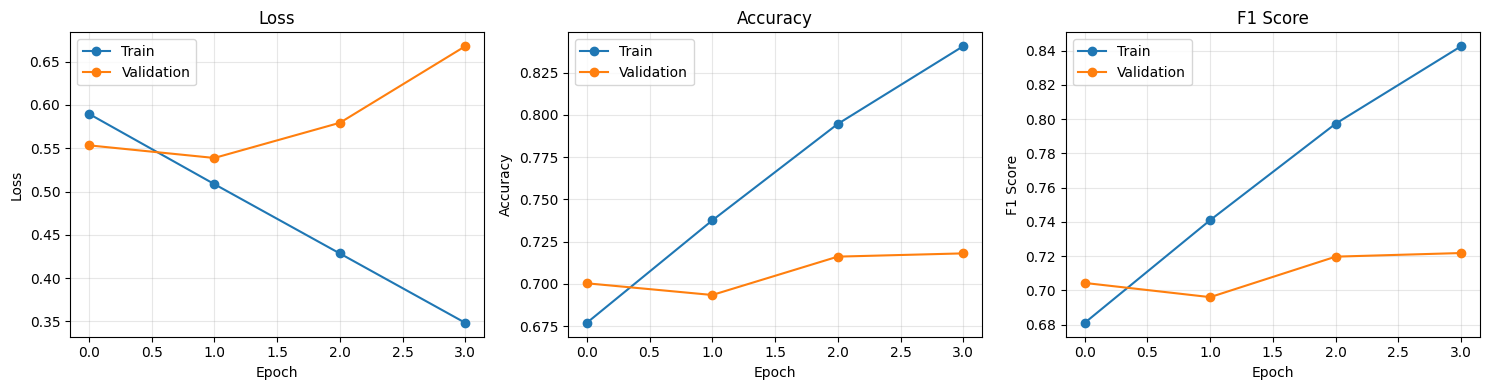

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))


axes[0].plot(history["train_loss"], label="Train", marker="o")
axes[0].plot(history["val_loss"], label="Validation", marker="o")
axes[0].set_title("Loss")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Loss")
axes[0].legend()
axes[0].grid(True, alpha=0.3)


axes[1].plot(history["train_acc"], label="Train", marker="o")
axes[1].plot(history["val_acc"], label="Validation", marker="o")
axes[1].set_title("Accuracy")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Accuracy")
axes[1].legend()
axes[1].grid(True, alpha=0.3)


axes[2].plot(history["train_f1"], label="Train", marker="o")
axes[2].plot(history["val_f1"], label="Validation", marker="o")
axes[2].set_title("F1 Score")
axes[2].set_xlabel("Epoch")
axes[2].set_ylabel("F1 Score")
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(MODEL_DIR, "training_history.png"), dpi=150)
plt.show()

In [ ]:
checkpoint = torch.load(os.path.join(MODEL_DIR, "best_model.pt"))
model.load_state_dict(checkpoint["model_state_dict"])
print(
  f"Loaded best model from epoch {checkpoint['epoch'] + 1} with Val F1: {checkpoint['val_f1']:.4f}"
)


test_results = evaluate(model, test_loader, DEVICE)

print("\n" + "=" * 60)
print("TEST SET RESULTS")
print("=" * 60)
print(f"Accuracy:  {test_results['accuracy']:.4f}")
print(f"F1 Score:  {test_results['f1']:.4f}")
print(f"Precision: {test_results['precision']:.4f}")
print(f"Recall:    {test_results['recall']:.4f}")
print("=" * 60)

Loaded best model from epoch 4 with Val F1: 0.7218


Evaluating:   0%|          | 0/163 [00:00<?, ?it/s]


TEST SET RESULTS
Accuracy:  0.7400
F1 Score:  0.7435
Precision: 0.7640
Recall:    0.7400


In [ ]:
print("\nClassification Report:")
print("-" * 60)
print(
  classification_report(
    test_results["labels"],
    test_results["predictions"],
    target_names=["Fake (0)", "Real (1)"],
  )
)


Classification Report:
------------------------------------------------------------
              precision    recall  f1-score   support

    Fake (0)       0.85      0.70      0.77      1598
    Real (1)       0.63      0.80      0.70      1002

    accuracy                           0.74      2600
   macro avg       0.74      0.75      0.74      2600
weighted avg       0.76      0.74      0.74      2600



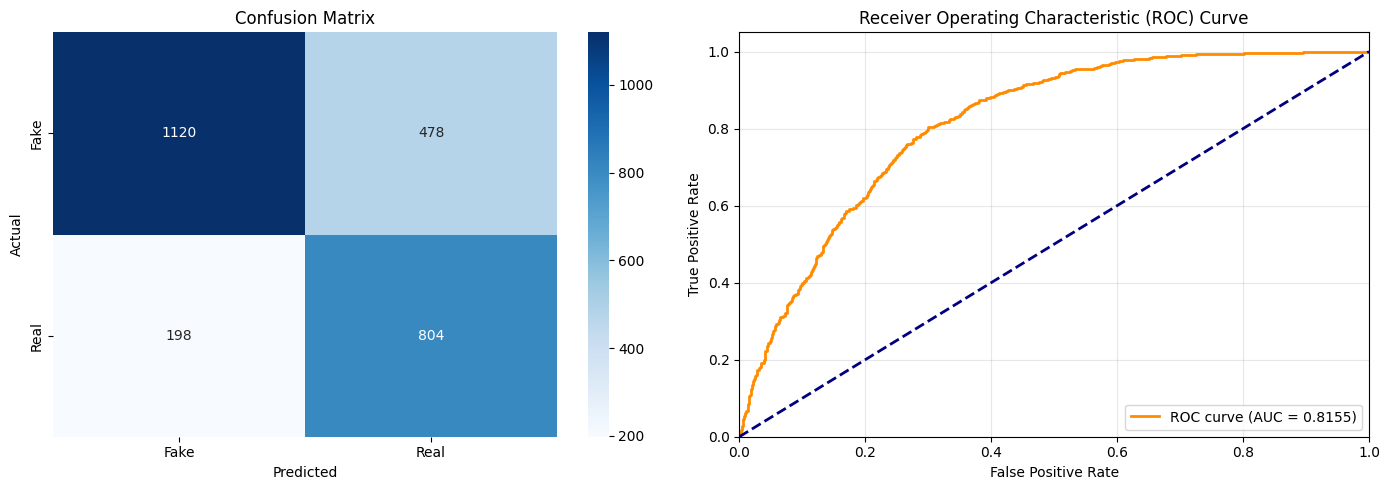


ROC-AUC Score: 0.8155


In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))


cm = confusion_matrix(test_results["labels"], test_results["predictions"])
sns.heatmap(
  cm,
  annot=True,
  fmt="d",
  cmap="Blues",
  ax=axes[0],
  xticklabels=["Fake", "Real"],
  yticklabels=["Fake", "Real"],
)
axes[0].set_title("Confusion Matrix")
axes[0].set_xlabel("Predicted")
axes[0].set_ylabel("Actual")


fpr, tpr, _ = roc_curve(test_results["labels"], test_results["probabilities"])
roc_auc = auc(fpr, tpr)

axes[1].plot(
  fpr, tpr, color="darkorange", lw=2, label=f"ROC curve (AUC = {roc_auc:.4f})"
)
axes[1].plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
axes[1].set_xlim([0.0, 1.0])
axes[1].set_ylim([0.0, 1.05])
axes[1].set_xlabel("False Positive Rate")
axes[1].set_ylabel("True Positive Rate")
axes[1].set_title("Receiver Operating Characteristic (ROC) Curve")
axes[1].legend(loc="lower right")
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(MODEL_DIR, "evaluation_results.png"), dpi=150)
plt.show()

print(f"\nROC-AUC Score: {roc_auc:.4f}")

In [ ]:
model.save_pretrained(os.path.join(MODEL_DIR, "fake_news_classifier"))
tokenizer.save_pretrained(os.path.join(MODEL_DIR, "fake_news_classifier"))

print(
  f"Model and tokenizer saved to: {os.path.join(MODEL_DIR, 'fake_news_classifier')}"
)

Model and tokenizer saved to: ./models/roberta_fake_news_classifier


In [ ]:
def predict_statement(text, model, tokenizer, device):
  """Predict if a statement is fake (0) or real (1) news."""
  model.eval()

  cleaned = clean_text(text)

  encoding = tokenizer(
    cleaned,
    max_length=MAX_LENGTH,
    padding="max_length",
    truncation=True,
    return_tensors="pt",
  )

  input_ids = encoding["input_ids"].to(device)
  attention_mask = encoding["attention_mask"].to(device)

  with torch.no_grad():
    outputs = model(input_ids=input_ids, attention_mask=attention_mask)
    probs = torch.softmax(outputs.logits, dim=1)
    pred = torch.argmax(probs, dim=1).item()
    confidence = probs[0][pred].item()

  label = "Real" if pred == 1 else "Fake"
  return {"prediction": label, "confidence": confidence, "class": pred}


sample_statements = [
  "The moon landing was faked by NASA in a Hollywood studio.",
  "Scientists confirm that regular exercise improves cardiovascular health.",
]

print("Sample Predictions:")
print("-" * 60)
for stmt in sample_statements:
  result = predict_statement(stmt, model, tokenizer, DEVICE)
  print(f"Statement: {stmt[:70]}...")
  print(f"Prediction: {result['prediction']} (Confidence: {result['confidence']:.2%})")
  print("-" * 60)

Sample Predictions:
------------------------------------------------------------
Statement: The moon landing was faked by NASA in a Hollywood studio....
Prediction: Fake (Confidence: 99.61%)
------------------------------------------------------------
Statement: Scientists confirm that regular exercise improves cardiovascular healt...
Prediction: Fake (Confidence: 96.42%)
------------------------------------------------------------
